<a href="https://colab.research.google.com/github/cjpdrury/evidence_networks/blob/fluxes/evidence_network_flux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evidence Network example on galaxy photometries
Charlie Drury and Niall Jeffrey, UCL

09/11/2023

The following notebook demonstrates use of an evidence network to derive Bayes factors. The data consists of galaxy photometries derived from two models; Illustris TNG (model $M_0$) and Simba (model $M_1$). The network is trained on a subset of labelled TNG and Simba data. The trained network is then used on test data to calculate Bayes factors for each galaxy.

The evidence network accuracy is assessed using a coverage test. It's performance is compared to a density estimation method using PZFlow.

Further details of techniques used in this notebook are available from "Evidence Networks: simple losses for fast, amortized, neural
Bayesian model comparison" by Niall Jeffrey and Benjamin D. Wandelt (2023). Available at: https://arxiv.org/abs/2305.11241.



In [1]:
# install this version of tf to use decayed lr metric
!pip install tensorflow==2.8.0
!pip install pzflow matplotlib




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 53.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing insta

In [2]:

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Sep  9 09:26:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
from scipy.stats import norm, multivariate_normal
import sys, os, time, gc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LeakyReLU, Input,ReLU
from tensorflow.keras import optimizers, callbacks
import h5py

from tensorflow.keras.layers import concatenate, BatchNormalization

import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import requests
import time

from pzflow import Flow
from pzflow.examples import get_twomoons_data

import jax.numpy as jnp


import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['image.cmap'] = 'coolwarm'
plt.rcParams["figure.facecolor"] = "white"
print(tf.config.list_physical_devices('GPU'))
tf.print(tf.constant([0.0]))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[0]
2.8.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')
# !cd /content/drive/MyDrive/ML_Intern/

path = '/content/drive/MyDrive/ML_Intern'



Mounted at /content/drive


## Write flux data to numpy
The data is stored as two HDF5 files, containing SIMBA and TNG simulations. The following cell only needs to be ran once, to store the data as a numpy file. The data used in this notebook is Green 'g' and Red 'r' Sloan filters. Future work could expand this to all available Sloan filters (ugriz)

In [137]:
# for each file in TNG and SIMBA, extract chosen fluxes.
f_TNG = h5py.File(path+'/TNG_master.hdf5', 'r')
f_SIM = h5py.File(path+'/simba_master.hdf5', 'r')


g_TNG, g_SIM, r_TNG,r_SIM = [],[],[],[]

# loop through each folder. Extract all galaxies from chosen filter.
for i in range(len(f_TNG.keys())):
  data = np.array(f_TNG[str(i)]['intrinsic']['SLOAN']['SDSS.g'])
  g_TNG.append(data)
  data = np.array(f_TNG[str(i)]['intrinsic']['SLOAN']['SDSS.r'])
  r_TNG.append(data)


for i in range(len(f_SIM.keys())):
  data = np.array(f_SIM[str(i)]['intrinsic']['SLOAN']['SDSS.g'])
  g_SIM.append(data)
  data = np.array(f_SIM[str(i)]['intrinsic']['SLOAN']['SDSS.r'])
  r_SIM.append(data)


flux_TNG = np.stack((np.concatenate(g_TNG).ravel(), np.concatenate(r_TNG).ravel()), axis=1)
flux_SIM = np.stack((np.concatenate(g_SIM).ravel(), np.concatenate(r_SIM).ravel()), axis=1)

np.save(path+'/flux_TNG.npy',flux_TNG)
np.save(path+'/flux_SIMBA.npy',flux_SIM)

## Load flux data from numpy file

In [138]:
# unpack data
flux_TNG = np.load(path+'/flux_TNG.npy')
flux_sim = np.load(path+'/flux_SIMBA.npy')
print(np.shape(flux_TNG))

# get headers and convert to pandas
header = 'sloan_g | sloan_r'
header = header.split('|')

df_TNG = pd.DataFrame(flux_TNG, columns=header)
df_SIM = pd.DataFrame(flux_SIM, columns=header)

# add model labels 'm'
df_TNG['m'] = np.zeros(df_TNG.shape[0])
df_SIM['m'] = np.ones(df_SIM.shape[0])

df_TNG.head()

(2413891, 2)


,sloan_g,sloan_r,m
0,1.008265e+30,1.561652e+30,0.0
1,2.232865e+29,3.288638e+29,0.0
2,4.372902e+28,6.529679e+28,0.0
3,8.979900e+27,1.011223e+28,0.0
4,4.124089e+28,5.184374e+28,0.0


In [139]:
# assign label of 0 for IllustrisTNG and 1 for SIMBA
flux_TNG = np.append(flux_TNG, np.zeros((len(flux_TNG[:,0]),1)) ,axis=1)
flux_SIM = np.append(flux_SIM, np.ones((len(flux_SIM[:,0]),1)) ,axis=1)

In [140]:
# combine into one dataset
train_flux = np.append(flux_TNG,flux_SIM, axis=0 )

## Produce training, validation and testing data
The fluxes are scaled to have a mean of zero and standard deviation of 1.

In [141]:
# randomly sample from training data

n_sample = 500000
# n_sample = train_data.shape[0]

choices = np.random.choice(train_flux.shape[0],
                                  size=n_sample,
                                  replace=False)
train_flux = train_flux[choices,:]
print(train_flux.shape)


# separate training, validation and test data
x_train, x_test, y_train, y_test = train_test_split(train_flux[:,:-1], train_flux[:,-1], test_size=0.20, shuffle=True, random_state=44)
x_train, x_val, y_train, y_val = train_test_split(x_train[:,:], y_train[:], test_size=0.20, shuffle=True, random_state=43)

(500000, 3)


In [142]:
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape,y_test.shape )

(320000, 2) (80000, 2) (100000, 2) (320000,) (80000,) (100000,)


In [143]:
# remove zero valued fluxes.
y_train = y_train[~np.all(x_train == 0, axis=1)]
x_train = x_train[~np.all(x_train == 0, axis=1)]



In [144]:
print(np.mean(x_train[:,0]), np.std(x_train[:,0]), np.max(x_train[:,0]), np.min(x_train[:,0]))

9.952589224592624e+27 7.938559338739665e+28 1.1724149124505068e+31 1.7991640493523012e+24


(array([4.03313506e-05, 1.61325403e-04, 1.20994052e-04, 2.01656753e-04,
        2.82319454e-04, 3.62982156e-04, 8.06627013e-04, 1.33093457e-03,
        1.61325403e-03, 3.02485130e-03, 3.42816480e-03, 5.60605774e-03,
        5.80771449e-03, 9.96184361e-03, 9.88118090e-03, 1.59712148e-02,
        1.88750721e-02, 2.14159472e-02, 2.89982411e-02, 4.72683429e-02,
        4.61390651e-02, 5.74721746e-02, 7.09025144e-02, 8.36472212e-02,
        1.07523381e-01, 1.07079736e-01, 1.36481291e-01, 1.30229931e-01,
        1.40353100e-01, 1.51081239e-01, 1.45959158e-01, 1.58018232e-01,
        1.58986184e-01, 1.63422633e-01, 1.62857994e-01, 1.59833143e-01,
        1.54267416e-01, 1.59913805e-01, 1.69149685e-01, 1.72739175e-01,
        1.71004927e-01, 1.75320381e-01, 1.76449659e-01, 1.91573915e-01,
        1.87177798e-01, 1.90323644e-01, 1.91936898e-01, 1.92622531e-01,
        1.90162318e-01, 1.94518104e-01, 1.94437441e-01, 1.99720848e-01,
        1.93832471e-01, 1.94114791e-01, 1.92864519e-01, 1.939131

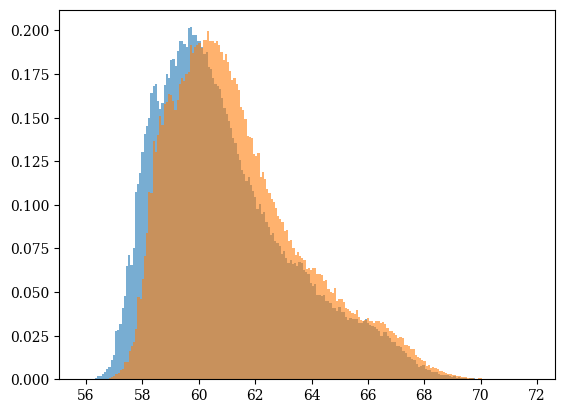

In [145]:
# check distributions
plt.hist(np.log(x_train[:,0]),bins=200, density=True, alpha=0.6)
plt.hist(np.log(x_train[:,1]),bins=200, density=True, alpha=0.6)

In [147]:
# normalise each set of data.

x_train_scaled = np.copy(x_train)
x_train_scaled[:,:2] = np.log(x_train_scaled[:,:2])
scaler = StandardScaler()
scaler.fit(x_train_scaled)
x_train_scaled = scaler.transform(x_train_scaled)/20.+0.5

def data_scaler(data):
    """
    Scales input testing and validation data
    """

    data_scaled = np.copy(data)
    data_scaled[:,:2] = np.log(data[:,:2])
    data_scaled = scaler.transform(data_scaled)/20.+0.5

    return data_scaled

x_test_scaled = data_scaler(x_test)
x_val_scaled = data_scaler(x_val)

In [148]:
print(np.mean(x_test_scaled[:,1]), np.std(x_test_scaled[:,1]), np.max(x_test_scaled[:,1]), np.min(x_test_scaled[:,1]))

0.4998044317502592 0.049648486254359483 0.7261237378809831 0.38476994832445277


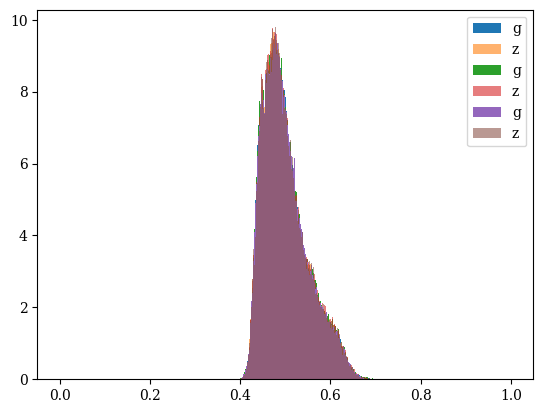

In [149]:
# check distributions match
_ = plt.hist(x_train_scaled[:,1],bins=np.linspace(-0,1,512),density=True, label='g')
_ = plt.hist(x_train_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True, label='z')

_ = plt.hist(x_val_scaled[:,1],bins=np.linspace(-0,1,512),density=True, label='g')
_ = plt.hist(x_val_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True, label='z')

_ = plt.hist(x_test_scaled[:,1],bins=np.linspace(-0,1,512),density=True, label='g')
_ = plt.hist(x_test_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True, label='z')

plt.legend()

The following cell checks the ratio of models in each dataset. This is so the density estimation can be rescaled later.

In [150]:
def M_ratio(y):
  scale = np.sum(y)/np.sum(1 - y)
  return scale

print(M_ratio(y_train), M_ratio(y_val), M_ratio(y_test))




1.290753944391948 1.296540835366729 1.2907408255829935


## Define functions for network

In [151]:
def smooth_sign(x, k =100.):

    return 2.*tf.math.sigmoid(k*x) - 1


def parity_odd_power(x, alpha=2):
    return (x)*(tf.math.abs(x)**(alpha-1))


# def leaky_parity_odd_power(x, alpha=2):
#     x_transition = (alpha)**(alpha/(1.-alpha))
#     shift=(alpha)**(1./(1.-alpha)) - x_transition
#     return tf.where(tf.math.abs(x)<x_transition, x, tf.sign(x)*tf.math.abs(x+tf.sign(x)*shift)**alpha)


def leaky_parity_odd_power(x, alpha=2):
    return x + parity_odd_power(x, alpha)

In [165]:
# Evidence Net functions:

class POPExpLoss(tf.keras.losses.Loss):
    """
    Custom exponential loss
    """

    def call(self, model_label, model_pred):
        model_pred =  leaky_parity_odd_power(model_pred, alpha=1)
        model_pred = tf.clip_by_value(model_pred, -50, 50)
        loss_val =  tf.math.exp((0.5 - model_label) * (model_pred) )
        return tf.reduce_mean(loss_val)


class ExpLoss(tf.keras.losses.Loss):
    """
    Custom exponential loss
    """

    def call(self, model_label, model_pred):
        model_pred = tf.clip_by_value(model_pred, -50, 50)
        loss_val =  tf.math.exp((0.5 - model_label) * (model_pred) )
        return tf.reduce_mean(loss_val)


def get_lr_metric(optimizer):
    """
    Learning rate on-the-fly
    :param optimizer:
    :return: learning rate
    """
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)  # I use ._decayed_lr method instead of .lr
        # return optimizer.lr(tf.float32) #C try .lr
    return lr



class DenseNetwork:
    """
    Network that takes in data and returns functions of the Bayesian evidence
    """

    def __init__(self, input_size, weight_init='he_normal', layer_width=100, added_layers=3,
                 learning_rate=1e-4, decay_rate=None, batch_norm_flag=1, residual_flag=0):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.layer_width = layer_width
        self.weight_init = weight_init
        self.decay_rate = decay_rate
        self.added_layers = added_layers
        self.batch_norm_flag = batch_norm_flag
        self.residual_flag = residual_flag


        print('Hyper-parameters:', input_size, weight_init, layer_width, added_layers,
              learning_rate, decay_rate, batch_norm_flag, residual_flag)

    def simple_layer(self, x_in):
        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_in)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        # x_out = tf.tanh(x_out)
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)
        return x_out

    def residual_block(self, x_in):
        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_in)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        # x_out = tf.tanh(x_out)
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)

        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_out)
        x_out = LeakyReLU(alpha=0.1)(x_out) + x_in
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)

        return x_out

    def model(self):

        input_data = (Input(shape=(self.input_size,)))


        x1 = Dense(int(1.1*self.input_size)+20, input_dim=self.input_size, kernel_initializer=self.weight_init)(input_data)
        x_inner = LeakyReLU(alpha=0.1)(x1)
        x_inner = BatchNormalization()(x_inner)
        x_inner = Dense(self.layer_width, input_dim=self.input_size, kernel_initializer=self.weight_init)(x_inner)
        x_inner = LeakyReLU(alpha=0.1)(x_inner)
        x_inner = BatchNormalization()(x_inner)

        # x_inner = tf.tanh(x1)

        for i in range(self.added_layers):
            x_inner = self.residual_block(x_inner)
            # x_inner = self.simple_layer(x_inner)

        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_inner)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        x_out = Dense(1, kernel_initializer=self.weight_init)(x_out)
        x_out = 0.1*x_out + 0.001
        ### alpha scaled here
        x_out = leaky_parity_odd_power(x_out, alpha=1)
        ###

        dense_model = Model(input_data, x_out)

        if self.decay_rate is not None:
            lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=self.learning_rate,
                                                                decay_steps=5000,
                                                                decay_rate=self.decay_rate)
            optimizer = optimizers.Adam(learning_rate=lr_schedule)
            lr_metric = get_lr_metric(optimizer)
            dense_model.compile(optimizer=optimizer,
                                loss=ExpLoss(),
                                metrics=[lr_metric])
        else:
            dense_model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                                loss=ExpLoss())

        return dense_model



class CustomCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Loss: {:.5e}. Val loss: {:.5e}".format(logs['loss'], logs['val_loss']))


# Evidence Net
Network parameters below are set to the best values found during network tuning. Note also that $\alpha $ can be scaled in the cell above. An ensemble of networks are trained with their Bayes factor predictions averaged to improve the accuracy.

In [ ]:
model_instances, model_instances_model,histories,results = [],[],[],[]

# input size, epochs, number of ensembles
N = x_train_scaled.shape[1]
epochs = 50
n_models = 3

with tf.device('/device:GPU:0'):
    for model_count in range(n_models):
        model_instances.append(DenseNetwork(N, weight_init='he_normal',
                                            layer_width=45, added_layers=3,
                                            learning_rate=1e-4, decay_rate=0.9,
                                            batch_norm_flag=1))
        model_instances_model.append(model_instances[-1].model())

        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
        histories.append(model_instances_model[-1].fit(x_train_scaled,y_train,
            epochs=epochs, batch_size=150,
                             shuffle=True,
                             validation_data = (x_val_scaled, y_val),
                             callbacks = [early_stop],
                             verbose=1))
        gc.collect()

Hyper-parameters: 2 he_normal 45 3 0.0001 0.9 1 0
Epoch 1/50
2134/2134 [==============================] - 28s 12ms/step - loss: 0.5094 - lr: 9.7784e-05 - val_loss: 0.4113 - val_lr: 9.5602e-05
Epoch 2/50
2134/2134 [==============================] - 23s 11ms/step - loss: 0.4290 - lr: 9.3484e-05 - val_loss: 0.4185 - val_lr: 9.1399e-05
Epoch 3/50
2134/2134 [==============================] - 26s 12ms/step - loss: 0.4217 - lr: 8.9373e-05 - val_loss: 0.4471 - val_lr: 8.7380e-05
Epoch 4/50
2134/2134 [==============================] - 23s 11ms/step - loss: 0.4172 - lr: 8.5444e-05 - val_loss: 0.4033 - val_lr: 8.3537e-05
Epoch 5/50
2134/2134 [==============================] - 25s 12ms/step - loss: 0.4138 - lr: 8.1686e-05 - val_loss: 0.4102 - val_lr: 7.9864e-05
Epoch 6/50
2134/2134 [==============================] - 23s 11ms/step - loss: 0.4109 - lr: 7.8095e-05 - val_loss: 0.3992 - val_lr: 7.6353e-05
Epoch 7/50
2134/2134 [==============================] - 24s 11ms/step - loss: 0.4095 - lr: 7.4661e

## Network tuning
Validation losses are plotted to evaluate network tuning.

In [154]:
# print the final loss and validation losses
losses, val_losses,stopping = [],[],[]
for i in range(len(histories)):
  losses.append( round(histories[i].history['loss'][-1], 4))
  val_losses.append( round(histories[i].history['val_loss'][-1], 4))
  stopping.append(len(histories[i].history['val_loss']))
  # histories[0].history['loss'][-1]

print('parameter values:\n')
print('losses:\n',losses)
print('val_losses:\n',val_losses)
print('early stopping:\n',stopping)

parameter values:

losses:
 [0.3966, 0.3926, 0.3926]
val_losses:
 [0.383, 0.3837, 0.3809]
early stopping:
 [50, 50, 50]


(0.0, 1.0)

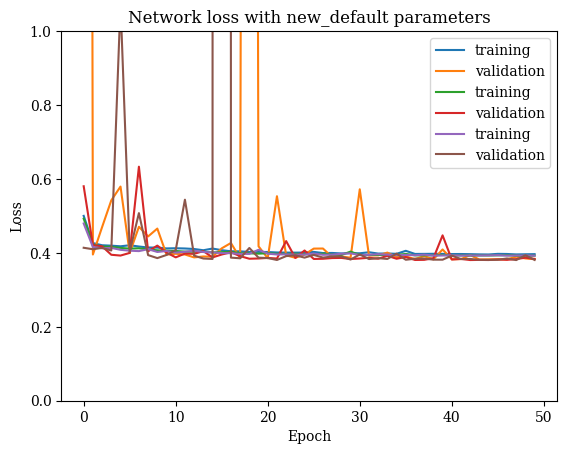

In [155]:
title = 'new_default'

plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.title('Network loss with varying '+title+r' ($\theta$)')
plt.title('Network loss with new_default parameters')
for i in range(len(histories)):

    _ = plt.plot(histories[i].history['loss'][:],label=r'training')#; $\theta$='+str(expt_value[i]))
    _ = plt.plot(histories[i].history['val_loss'][:],label=r'validation')#; $\theta$='+str(expt_value[i]))
    # save the history
    # np.save(path+'/network_tuning/'+title+'_'+str(expt_value[i])+'.npy',histories[0].history)
    # np.save(path+'/network_tuning/'+title+'.npy',histories[0].history)
plt.legend()
plt.ylim(0,1)
# plt.xlim(0,90)
# plt.savefig(path+'/network_tuning/'+title, dpi=250)


Metric data can be loaded from the numpy file as below

In [156]:
# note the .item() is important
data = np.load(path+'/network_tuning/batch_size_100.npy',allow_pickle=True).item()
data['val_accuracy'][-1]

0.7307199835777283

## Network Output
The network estimates log K values for the test data. As the ratio of priors is not 1, the network predictions should be transformed to give logK.

In [157]:
# collect network outputs f(xO).
validation_prediction = (model_instances_model[0].predict(x_test_scaled))
for i in range(n_models-1):
  temp = (model_instances_model[i+1].predict(x_test_scaled))
  validation_prediction = np.append(validation_prediction, temp, axis=1)


0
1


In [158]:
# calucalte mean average output
validation_prediction_avg = np.mean(validation_prediction, axis=1)
print(validation_prediction)
print(validation_prediction_avg)

[[-1.6643902  -1.6460869  -1.6726782 ]
 [21.215334   15.393588   20.644796  ]
 [-0.72581077 -0.70378315 -0.7024364 ]
 ...
 [-2.7954721  -2.2580538  -2.8941278 ]
 [49.988213   52.712994   34.07061   ]
 [-5.0372143  -5.2480526  -4.7905297 ]]
[-1.6610518 19.084572  -0.7106767 ... -2.6492178 45.590607  -5.025265 ]


# Coverage tests
Coverage tests are used to evaluate the network output.

Posterior probabilities p(M1|x) are calculated from the network output on test data. The posteriors are binned. The fraction of model 1 labels (Simba) in each bin are examined. The fraction of model 1 labels in each bin should be close to the bin centre to show the network is well calibrated, forming a y=x line. The residual differences from the y=x line are used to measure the network performance.



In [159]:
# calculate posteriors from network log K values
posterior_model_prob = np.exp(validation_prediction_avg)/(1+np.exp(validation_prediction_avg)) # p(M1|x)
print(posterior_model_prob.shape)

# prepare posterior bins
nbins = 100
probability_array  = np.linspace(0,1,nbins)


(100000,)


<ipython-input-159-f57fd1c47967>:2: RuntimeWarning: overflow encountered in exp
  posterior_model_prob = np.exp(validation_prediction_avg)/(1+np.exp(validation_prediction_avg)) # p(M1|x)
<ipython-input-159-f57fd1c47967>:2: RuntimeWarning: invalid value encountered in divide
  posterior_model_prob = np.exp(validation_prediction_avg)/(1+np.exp(validation_prediction_avg)) # p(M1|x)


In [160]:
def coverage_test(post_model_prob, prob_array):
  '''
  Performs the coverage tests to evaluate calibration of the network
  :param post_model_prob: array of p(M1|x) predicted by network
  :param prob_array: array of chosen bins for posteriors
  :returns: posterior bin centres, validation fractions, post_bin_n (number of data prob in each bin),
            binomial_std (standard error of binomial)
  '''

  # perform coverage test
  bin_centres, fractions, post_bin_n = [],[],[]

  for i in range(0,len(prob_array)-1):
    # bin posteriors
    indexes = np.where((post_model_prob > prob_array[i])
                                        & (post_model_prob < prob_array[i+1]))[0]
    post_bin = post_model_prob[indexes]
    post_bin_mid = np.float32((prob_array[i]+prob_array[i+1]) / 2)
    post_bin_size = np.float32(len(post_bin))

    # get fraction of model 1 labels in each bin
    label_bin = y_test[indexes]
    fraction = np.sum(label_bin) / len(label_bin)

    bin_centres.append(post_bin_mid), fractions.append(fraction), post_bin_n.append(post_bin_size)


  # get the binomial error for each bin
  binomial_std = np.sqrt((np.asarray(bin_centres)*(1.-np.asarray(bin_centres))) / np.asarray(post_bin_n))

  return bin_centres, fractions, post_bin_n, binomial_std

In [161]:
bin_centres, fractions, post_bin_n, binomial_std = coverage_test(posterior_model_prob, probability_array)

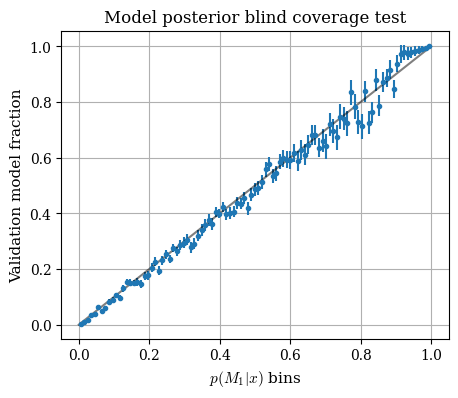

In [162]:
plt.figure(figsize=(5,4))

# plt.plot(bin_centres, fractions,'.')
# plt.plot(post_bin_means, fractions,'.')
plt.errorbar(bin_centres, fractions, np.asarray(binomial_std), marker='.', ls='')
plt.title('Model posterior blind coverage test')
plt.xlabel(r'$p(M_1 | x)$ bins', fontsize=11)
plt.ylabel(str('Validation model fraction'), fontsize=11)
plt.plot([0,1],[0,1],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.savefig(path+'coverage_test_20_B.png', dpi=250)
# plt.axis('equal')

## Residual between model fraction and posterior probability from evidence network
Scaled residuals are the residuals scaled by their binomial error. The scaled residuals should form a normal distribution around 0. The network is said to perform well if the mean and standard deviation of the scaled residuals are close to 0 and 1 respectively.

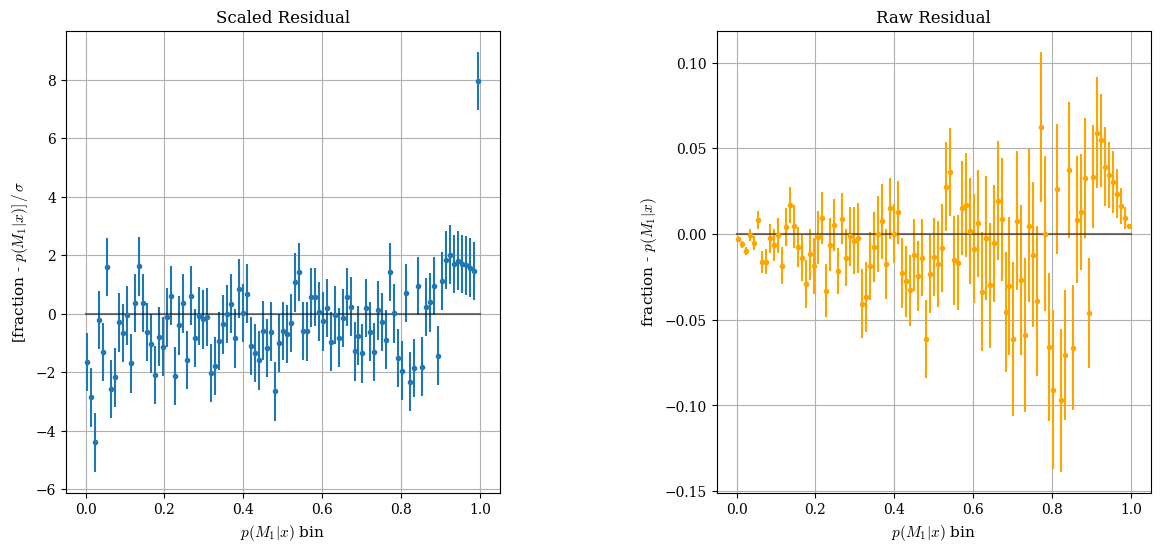

In [163]:
residual = (np.asarray(fractions) - np.asarray(bin_centres))
scaled_residual = residual/np.asarray(binomial_std)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.errorbar(bin_centres, scaled_residual,yerr=binomial_std/np.asarray(binomial_std), marker='.', ls='')
plt.title('Scaled Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] \, / \, \sigma$', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)
# plt.ylim(-4,4)

plt.subplot(1,2,2)
plt.errorbar(bin_centres, residual,yerr=binomial_std, marker='.', ls='',c='orange')
plt.title('Raw Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'fraction - $p(M_1 | x)  $', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplots_adjust(wspace=.5)

# plt.savefig(path+'/residuals_unobservables_EvidenceNet.png', dpi=250)


In [164]:
print(np.mean(scaled_residual))
print(np.std(scaled_residual))

-0.28319087073220817
1.4742651391461032


## Normalising flows
The following cells use the package PZ Flow to learn the probability density function of the data. We train the neural density estimator to estimate p(x|M1) and p(x|M0), then derive the Bayes factor from this.

In [103]:
# turn datasets into pandas dataframe for PZ Flow.
train_df = pd.DataFrame({'stellar_mass': x_train_scaled[:,0], 'stellar_metallicity': x_train_scaled[:,1], 'model': y_train})
val_df = pd.DataFrame({'stellar_mass': x_val_scaled[:,0], 'stellar_metallicity': x_val_scaled[:,1], 'model': y_val})
test_df = pd.DataFrame({'stellar_mass': x_test_scaled[:,0], 'stellar_metallicity': x_test_scaled[:,1], 'model': y_test})

# separate training and validation by model.
train_M1_df = train_df[train_df['model'] == 1]
train_M0_df = train_df[train_df['model'] == 0]
val_M1_df = val_df[val_df['model'] == 1]
val_M0_df = val_df[val_df['model'] == 0]




In [105]:
# train the normalising flow.
flow_M1 = Flow(["stellar_mass", 'stellar_metallicity'])

train_loss_M1, val_loss_M1 = flow_M1.train(train_M1_df, val_M1_df, verbose=True, epochs=50, batch_size=100, progress_bar=True)


Training 50 epochs 
Loss:
(0) -1.7143  -1.7152


  0%|          | 0/50 [00:00<?, ?it/s]

(1) -4.7030  -4.6961


  6%|▌         | 3/50 [00:39<08:44, 11.15s/it]

(3) -4.7357  -4.7299


 10%|█         | 5/50 [00:50<05:44,  7.65s/it]

(5) -4.7293  -4.7245


 14%|█▍        | 7/50 [00:59<04:18,  6.00s/it]

(7) -4.7421  -4.7353


 18%|█▊        | 9/50 [01:17<04:57,  7.25s/it]

(9) -4.7366  -4.7288


 22%|██▏       | 11/50 [01:31<04:41,  7.22s/it]

(11) -4.7316  -4.7250


 26%|██▌       | 13/50 [01:43<04:01,  6.54s/it]

(13) -4.7486  -4.7422


 30%|███       | 15/50 [01:53<03:14,  5.56s/it]

(15) -4.7365  -4.7293


 34%|███▍      | 17/50 [02:03<02:55,  5.31s/it]

(17) -4.7447  -4.7385


 38%|███▊      | 19/50 [02:15<02:55,  5.67s/it]

(19) -4.7261  -4.7186


 42%|████▏     | 21/50 [02:24<02:27,  5.07s/it]

(21) -4.7365  -4.7309


 46%|████▌     | 23/50 [02:35<02:22,  5.26s/it]

(23) -4.7575  7546569135286428132404304208199680.0000


 50%|█████     | 25/50 [02:44<02:05,  5.03s/it]

(25) -4.7469  -4.7412


 54%|█████▍    | 27/50 [02:55<01:55,  5.03s/it]

(27) -4.7557  -4.7487


 58%|█████▊    | 29/50 [03:05<01:50,  5.25s/it]

(29) -4.7507  -4.7443


 62%|██████▏   | 31/50 [03:15<01:34,  4.96s/it]

(31) -4.7493  -4.7425


 66%|██████▌   | 33/50 [03:26<01:28,  5.21s/it]

(33) -4.7541  -4.7478


 70%|███████   | 35/50 [03:35<01:14,  4.97s/it]

(35) -4.7571  -4.7500


 74%|███████▍  | 37/50 [03:48<01:14,  5.75s/it]

(37) -4.7356  -4.7289


 78%|███████▊  | 39/50 [03:59<01:02,  5.73s/it]

(39) -4.7572  -4.7513


 82%|████████▏ | 41/50 [04:17<01:07,  7.52s/it]

(41) -4.7538  -4.7483


 86%|████████▌ | 43/50 [04:26<00:42,  6.01s/it]

(43) -4.7646  -4.7573


 90%|█████████ | 45/50 [04:37<00:28,  5.74s/it]

(45) -4.7472  -4.7396


 94%|█████████▍| 47/50 [04:46<00:15,  5.24s/it]

(47) -4.7205  -4.7154


 98%|█████████▊| 49/50 [04:57<00:05,  5.15s/it]

(49) -4.7646  -4.7583


100%|██████████| 50/50 [05:01<00:00,  6.03s/it]

(50) -4.7410  -4.7335


In [106]:
flow_M0 = Flow(["stellar_mass", 'stellar_metallicity'])

train_loss_M0, val_loss_M0 = flow_M0.train(train_M0_df, val_M0_df, verbose=True, epochs=50, batch_size=100, progress_bar=True)

Training 50 epochs 
Loss:
(0) -2.0442  -2.0437


  2%|▏         | 1/50 [00:23<19:26, 23.81s/it]

(1) -5.6804  -5.6770


  6%|▌         | 3/50 [00:36<08:07, 10.37s/it]

(3) -5.7363  -5.7325


 10%|█         | 5/50 [00:43<04:41,  6.26s/it]

(5) -5.7138  -5.7113


 14%|█▍        | 7/50 [00:52<03:46,  5.28s/it]

(7) -5.7537  -5.7482


 18%|█▊        | 9/50 [00:59<02:57,  4.33s/it]

(9) -5.7756  -5.7712


 22%|██▏       | 11/50 [01:08<02:46,  4.27s/it]

(11) -5.7737  -5.7692


 26%|██▌       | 13/50 [01:15<02:27,  3.98s/it]

(13) -5.7686  -5.7646


 30%|███       | 15/50 [01:23<02:19,  3.99s/it]

(15) -5.7585  -5.7542


 34%|███▍      | 17/50 [01:31<02:09,  3.93s/it]

(17) -5.7748  -5.7704


 38%|███▊      | 19/50 [01:38<01:59,  3.87s/it]

(19) -5.7836  -5.7778


 42%|████▏     | 21/50 [01:50<02:19,  4.80s/it]

(21) -5.7852  -5.7792


 46%|████▌     | 23/50 [01:56<01:49,  4.07s/it]

(23) -5.7427  -5.7376


 50%|█████     | 25/50 [02:05<01:47,  4.31s/it]

(25) -5.6958  -5.6919


 54%|█████▍    | 27/50 [02:13<01:34,  4.11s/it]

(27) -5.8002  -5.7946


 58%|█████▊    | 29/50 [02:22<01:30,  4.29s/it]

(29) -5.7591  -5.7536


 62%|██████▏   | 31/50 [02:29<01:13,  3.89s/it]

(31) -5.7978  -5.7923


 66%|██████▌   | 33/50 [02:37<01:09,  4.08s/it]

(33) -5.8023  -5.7972


 70%|███████   | 35/50 [02:53<01:30,  6.05s/it]

(35) -5.7777  -5.7724


 74%|███████▍  | 37/50 [03:02<01:06,  5.10s/it]

(37) -5.8046  -5.7988


 78%|███████▊  | 39/50 [03:09<00:49,  4.48s/it]

(39) -5.8046  -5.8000


 82%|████████▏ | 41/50 [03:18<00:37,  4.22s/it]

(41) -5.7542  -5.7489


 86%|████████▌ | 43/50 [03:25<00:27,  3.89s/it]

(43) -5.7444  -5.7391


 90%|█████████ | 45/50 [03:33<00:20,  4.06s/it]

(45) -5.8052  -5.7992


 94%|█████████▍| 47/50 [03:40<00:11,  3.73s/it]

(47) -5.8024  -5.7967


 98%|█████████▊| 49/50 [03:49<00:04,  4.06s/it]

(49) -5.8100  -5.8045


100%|██████████| 50/50 [03:52<00:00,  4.66s/it]

(50) -5.7915  -5.7868


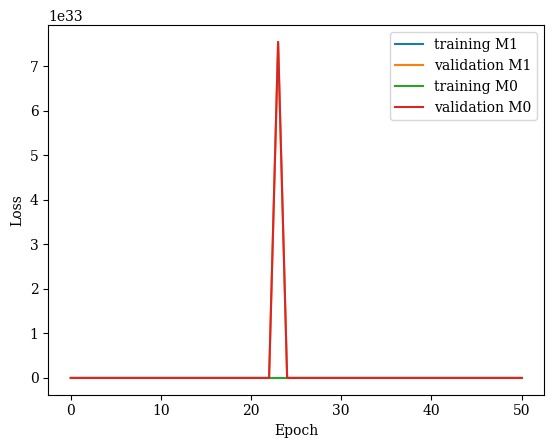

In [107]:
plt.plot(train_loss_M1, label='training M1')
plt.plot(val_loss_M1, label='validation M1')
plt.plot(train_loss_M1, label='training M0')
plt.plot(val_loss_M1, label='validation M0')
# plt.ylim(-5,-4)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Flow Output
The learnt densities are plotted alongside 2d histograms of the original data for each model.

In [109]:
def density(flow, xlim=(0.4,0.7), ylim=(0.4,0.7) ):
  '''
  Calculates a grid of density values
  '''

  nx, ny = (1000, 1000)
  x, y = np.linspace(xlim[0], xlim[1], nx), np.linspace(ylim[0], ylim[1], ny)
  # y = np.linspace(ylim[0], ylim[1], ny)
  xv, yv = np.meshgrid(x, y)
  X, Y = xv.flatten(), yv.flatten()
  # Y = yv.flatten()
  grid_df = pd.DataFrame({'stellar_mass': X, 'stellar_metallicity': Y})
  density = np.exp(flow.log_prob(grid_df))
  density = density.reshape((nx,ny))
  # matrix needs flipping.
  density = np.flipud(density)

  return density





In [110]:
# define grid limits for densities.
xx, yy = (0.4,0.65), (0.4,0.65)
dens_M1 = density(flow_M1, xx,yy)
dens_M0 = density(flow_M0, xx,yy)

[Text(0.5, 0, 'stellar mass (scaled)'),
 Text(0, 0.5, 'stellar metallicity (scaled)'),
 Text(0.5, 0, 'stellar mass (scaled)'),
 Text(0, 0.5, 'stellar metallicity (scaled)'),
 Text(0.5, 0, 'stellar mass (scaled)'),
 Text(0, 0.5, 'stellar metallicity (scaled)'),
 Text(0.5, 0, 'stellar mass (scaled)'),
 Text(0, 0.5, 'stellar metallicity (scaled)')]

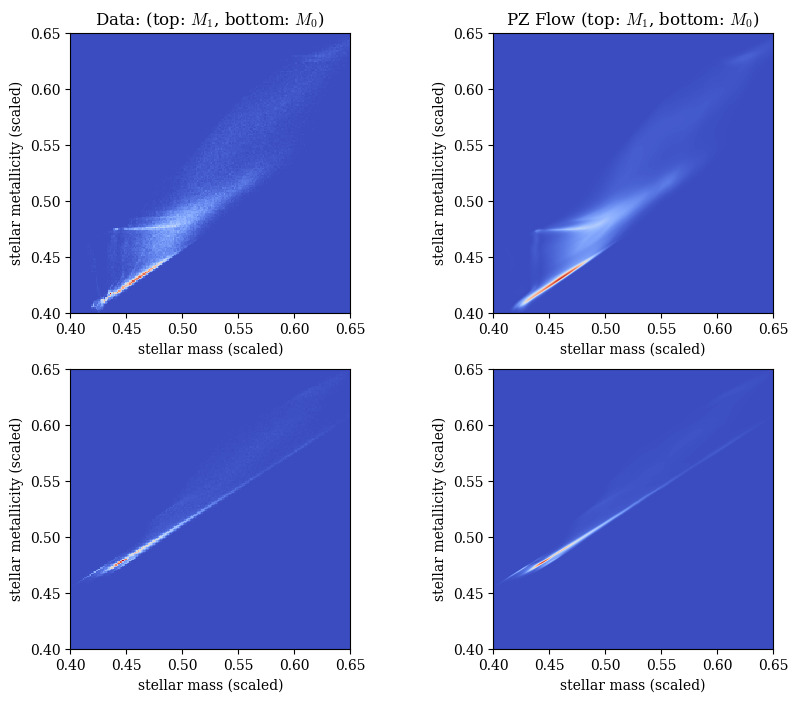

In [111]:
# plot outputs.
fig, ax = plt.subplots(2,2,  figsize=(10,8))

ax[0,0].set_title('Data: (top: $M_1$, bottom: $M_0$)')
ax[0,0].hist2d(train_M1_df.iloc[:,0],train_M1_df.iloc[:,1], bins=[np.linspace(xx[0],xx[1],200), np.linspace(yy[0],yy[1],200)])
ax[1,0].hist2d(train_M0_df.iloc[:,0],train_M0_df.iloc[:,1], bins=[np.linspace(xx[0],xx[1],200), np.linspace(yy[0],yy[1],200)])
ax[0,0].axis('square')
ax[1,0].axis('square')


ax[0,1].set_title('PZ Flow (top: $M_1$, bottom: $M_0$)')
ax[0,1].imshow(dens_M1,extent=[xx[0],xx[1],yy[0],yy[1]])
ax[1,1].imshow(dens_M0,extent=[xx[0],xx[1],yy[0],yy[1]])


plt.setp(ax, xlabel='stellar mass (scaled)' , ylabel='stellar metallicity (scaled)')

The flow outputs log( p(x|M1) ) and log( p(x|M0) ). We combine these to get log K.

In [121]:
logprob_M1 = flow_M1.log_prob(test_df)
logprob_M0 = flow_M0.log_prob(test_df)


In [122]:
# include priors ratio correction to compare output of EvidenceNet and PZFlow.
logK_flow = logprob_M1 -  logprob_M0 + np.log(M_ratio(y_test))

Calculate the Bayes factors and perform a coverage test.

inf inf


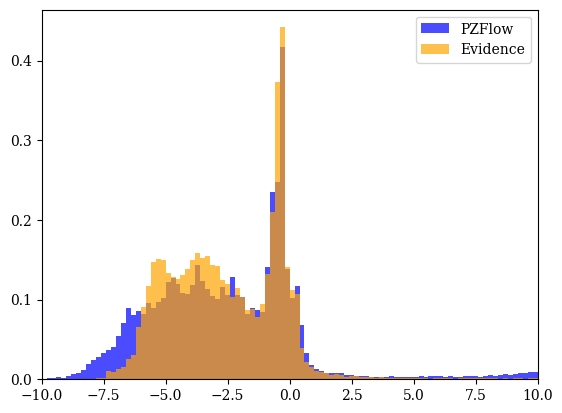

In [131]:
# print(np.mean(logK_flow), np.std(logK_flow))
plt.hist(logK_flow,bins=100,density=True, alpha=0.7,color='blue', label='PZFlow',range=(-10,10))
plt.hist(validation_prediction_avg,bins=100,density=True, alpha=0.7, color='orange', label='Evidence',range=(-10,10))
plt.xlim(-10,10)
plt.legend()

In [132]:
# get p(M1|x) from logK
post_flow = np.exp(logK_flow)/(1+np.exp(logK_flow))

# prepare posterior bins
nbins = 100
probability_array  = np.linspace(0,1,nbins)


<ipython-input-132-e144110becd1>:2: RuntimeWarning: overflow encountered in exp
  post_flow = np.exp(logK_flow)/(1+np.exp(logK_flow))
<ipython-input-132-e144110becd1>:2: RuntimeWarning: invalid value encountered in divide
  post_flow = np.exp(logK_flow)/(1+np.exp(logK_flow))


In [133]:
bin_centres_flow, fractions_flow, post_bin_n_flow, binomial_std_flow = coverage_test(post_flow, probability_array)

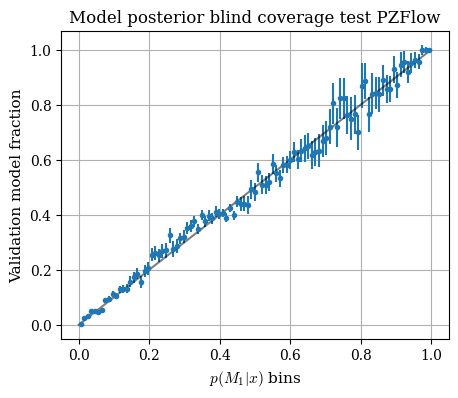

In [134]:
plt.figure(figsize=(5,4))

plt.errorbar(bin_centres_flow, fractions_flow, np.asarray(binomial_std_flow), marker='.', ls='')
plt.title('Model posterior blind coverage test PZFlow')
plt.xlabel(r'$p(M_1 | x)$ bins', fontsize=11)
plt.ylabel(str('Validation model fraction'), fontsize=11)
plt.plot([0,1],[0,1],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

# plt.savefig(path+'coverage_test_20_B.png', dpi=250)
# plt.axis('equal')

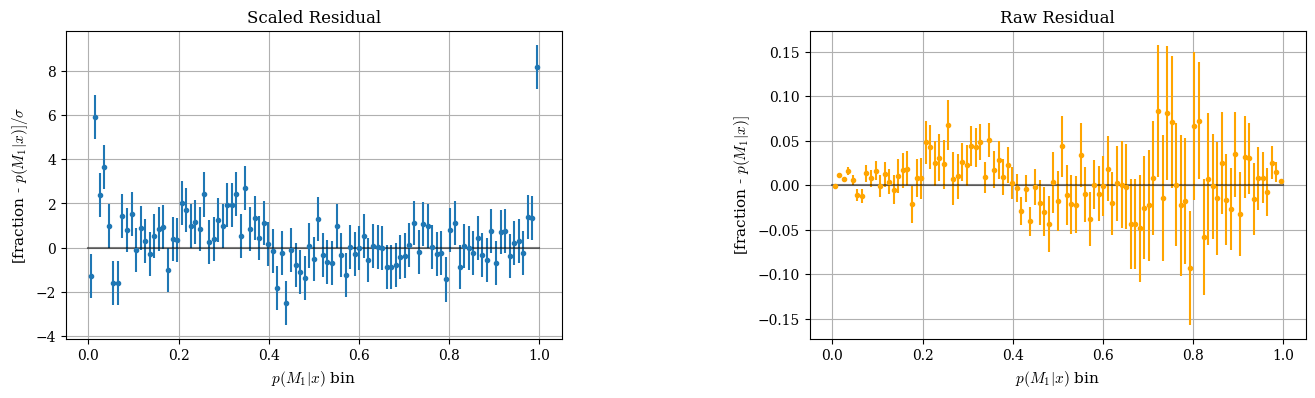

In [135]:
residual_flow = (np.asarray(fractions_flow) - np.asarray(bin_centres_flow))
scaled_residual_flow = residual_flow/np.asarray(binomial_std_flow)

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.errorbar(bin_centres_flow, scaled_residual_flow,yerr=binomial_std_flow/np.asarray(binomial_std_flow), marker='.', ls='')
plt.title('Scaled Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] / \sigma$', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplot(1,2,2)
plt.errorbar(bin_centres_flow, residual_flow,yerr=binomial_std_flow, marker='.', ls='',c='orange')
plt.title('Raw Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] $', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplots_adjust(wspace=.5)


In [136]:
print(np.mean(scaled_residual_flow))
print(np.std(scaled_residual_flow))

0.41200581999201613
1.4274167518321634


The coverage test produces scaled residuals with a lower mean and standard deviation compared to that of PZFLow, demonstrating its ability to estimate Bayes factors more accuracy.

In future work, the evidence network could be used to derive Bayes factors from real galaxy photometry data and subsequently determine which model ($M_0$ or $M_1$) is more probable.  